# Construct a custom Environment for Pair Trading

Some examples on the market
* [custom env example](https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/sb3/5_custom_gym_env.ipynb#scrollTo=RqxatIwPOXe_)
* [StockTradingEnv by Adam King](https://github.com/notadamking/Stock-Trading-Environment)
* [FinRL](https://github.com/AI4Finance-Foundation/FinRL)

Target is to construct a custom Env for pair trading

This env allows the learner to hold a position as a percentage



In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import csv
import math
import numpy as np
import pandas as pd
import gymnasium as gym
import statsmodels.api as sm

from gymnasium import spaces
from datetime import date
from envs.env_gridsearch import kellycriterion
from sklearn.model_selection import train_test_split
from stable_baselines3.common.vec_env import DummyVecEnv
from utils.read2df import read2df
from params import *
from envs.env_rl_freeop import PairTradingEnv

from stable_baselines3 import PPO, A2C, DQN

os.makedirs("result/rl-freeop", exist_ok=True)

# for root, dirs, files in os.walk(f"result/rl-freeop/"):
#     for file in files:
#         os.remove(os.path.join(root, file))

Load data from `preliminaries.ipynb`

In [2]:
import pickle

with open('result/cointncorr.pickle', 'rb') as pk:
    data = pickle.load(pk)

dfs = read2df(symbols=data[0], freqs={data[1]: freqs[data[1]]}, marketType='futures/um')

df0 = dfs[0][dfs[0]['tic']==data[0][0]].reset_index(drop=True)
df1 = dfs[0][dfs[0]['tic']==data[0][1]].reset_index(drop=True)

Set data before `trade_data` as training data, after `trade_data` is trade_data

In [3]:
train0 = df0[df0['datetime'] < trade_date]
train1 = df1[df1['datetime'] < trade_date]

test0 = df0[df0['datetime'] >= trade_date]
test1 = df1[df1['datetime'] >= trade_date]

print(f"The length of our training data: {len(train0)}")

The length of our training data: 902459


## Check with baselin3 `env_checker`

Check if the env meets the requirements of `stable_baseline3`

In [4]:
from stable_baselines3.common.env_checker import check_env
# > UserWarning: The action space is not based off a numpy array. Typically this means it's either a Dict or Tuple space. This type of action space is currently not supported by Stable Baselines 3. You should try to flatten the action using a wrapper.
# Baseline 3 does not support Dict/Tuple action spaces....only Box Discrete MultiDiscrete MultiBinary
# Is there another way to achieve the same functionality?

env = PairTradingEnv(train0, train1)
check_env(env)

## Do a test run with random generated actions

In [5]:
env = PairTradingEnv(train0, train1, tc=0, model="test")
obs, _ = env.reset()

print(f"observation_space: {env.observation_space}")
print(f"action_space: {env.action_space}")
print(f"action_space.sample: {env.action_space.sample()}")

n_steps = 20

for step in range(n_steps):
    obs, reward, terminated, truncated, info = env.step(action=env.action_space.sample())
    done = terminated or truncated
    env.render()
    if done:
        break

observation_space: Dict('compare_clos_thre': Discrete(3), 'compare_open_thre': Discrete(3), 'position': Box(-1.0, 1.0, (1,), float64), 'zscore': Box(-inf, inf, (1,), float64))
action_space: Discrete(3)
action_space.sample: 1


## Models from stable_baselines3

Train with training data

In [6]:
'''PPO'''

env = PairTradingEnv(train0, train1, tc=0, model="ppo")

model_ppo = PPO("MultiInputPolicy", env, verbose=0, tensorboard_log="logs")
model_ppo.learn(total_timesteps=20000)
model_ppo.save("result/rl-freeop/ppo_pairtrading")

In [7]:
'''A2C'''

env = PairTradingEnv(train0, train1, tc=0, model="a2c")

model_a2c = A2C("MultiInputPolicy", env, verbose=0)
model_a2c.learn(total_timesteps=20000)
model_a2c.save("result/rl-freeop/a2c_pairtrading")

In [8]:
'''DQN'''

env = PairTradingEnv(train0, train1, tc=0, model="dqn")

model_dqn = DQN("MultiInputPolicy", env, verbose=0)
model_dqn.learn(total_timesteps=20000)
model_dqn.save("result/rl-freeop/dqn_pairtrading")

## Use the model on Test data

In [26]:
# del model_ppo, model_a2c, model_dqn

model_ppo = PPO.load("result/rl-freeop/ppo_pairtrading.zip")
model_a2c = A2C.load("result/rl-freeop/a2c_pairtrading.zip")
model_dqn = DQN.load("result/rl-freeop/dqn_pairtrading.zip")

In [28]:
try:
    os.remove("result/rl-freeop/networth_ppo.csv")
except OSError:
    pass

env = PairTradingEnv(test0, test1, tc=0, model="ppo")
obs, _ = env.reset()

while True:
    action, _states = model_ppo.predict(obs)
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    env.render()
    if terminated:
        print("Test Finished!")
        break
    elif truncated:
        print("bankrupted!")
        break

Test Finished!


In [29]:
try:
    os.remove("result/rl-freeop/networth_a2c.csv")
except OSError:
    pass

env = PairTradingEnv(test0, test1, tc=0, model="a2c")
obs, _ = env.reset()

while True:
    action, _states = model_a2c.predict(obs)
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    env.render()
    if terminated:
        print("Test Finished!")
        break
    elif truncated:
        print("bankrupted!")
        break

Test Finished!


In [30]:
try:
    os.remove("result/rl-freeop/networth_dqn.csv")
except OSError:
    pass

env = PairTradingEnv(test0, test1, tc=0, model="dqn")
obs, _ = env.reset()

while True:
    action, _states = model_dqn.predict(obs)
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    env.render()
    if terminated:
        print("Test Finished!")
        break
    elif truncated:
        print("bankrupted!")
        break

Test Finished!


### Analyze with PyFolio

In [31]:
folder_path = f"result/rl-freeop/"
os.remove(f"{folder_path}networth_test.csv") if os.path.exists(f"{folder_path}networth_test.csv") else None
csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

best_res, best_model = None, None
for file_name in csv_files:
    file_path = os.path.join(folder_path, file_name)
    
    with open(file_path, 'r') as csv_file:
        csv_reader = csv.reader(csv_file)
        
        # Loop through the lines in the CSV file
        last_line = None
        for row in csv_reader:
            last_line = row  # Update last_line with the current row
    
    if best_res is None or float(best_res) < float(last_line[1]):
        best_res = last_line[1]
        best_model = file_name

    print(f"The ending capital of {file_name} is {last_line[0:2]}")

print(f"The best model is {best_model}")

The ending capital of networth_a2c.csv is ['2023-10-31 23:59:57.952000', '10088.973093700397']
The ending capital of networth_dqn.csv is ['2023-10-31 23:59:57.952000', '10343.917074107967']
The ending capital of networth_ppo.csv is ['2023-10-31 23:59:57.952000', '9972.022180111944']
The best model is networth_dqn.csv


In [32]:
from utils.rlmetrics import get_return, get_metrics

best_return = get_return(f'result/rl-freeop/{best_model}')
get_metrics(best_return)

Total orders count: 493469
Total long action: 245761
Total short action: 243206
Won orders count: 245761
Lost orders count: 243206
Win/Loss order ratio: 1.0105054973972682
Avg order pnl: 7.744727736266912e-08
Avg order pnl won: 8.757311680194123e-05
Avg order pnl lost: -8.833597414475384e-05
Avg long order pnl: -5.934004545152037e-08
Avg short order pnl: 5.904395183226748e-06


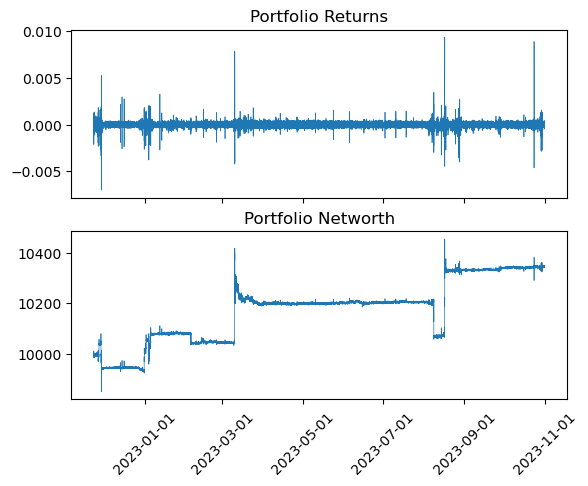

In [36]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(best_return.index, best_return['returns'], linewidth=0.5)
ax1.set_title("Portfolio Returns")

ax2.plot(best_return.index, best_return['values'], linewidth=0.5)
ax2.set_title("Portfolio Networth")

ax2.set_xticklabels(ax2.get_xticks(), rotation=45)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

In [25]:
# import pyfolio

# pyfolio.tears.create_full_tear_sheet(pd.Series(best_return['returns']))